# Packages

In [289]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm 
from math import pi 
from windrose import WindroseAxes
import matplotlib.ticker as ticker
import math 
import matplotlib.colors as colors
from scipy import linalg as LA
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['font.size'] = 8
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' 
plt.rcParams['figure.dpi'] = 100

# Data

In [290]:
df = pd.read_csv('extendedabstract.csv')

#Convert data to datetime dd/mm/yyyy HH:MM 
df['timestamp'] = pd.to_datetime(df.date,format='%d/%m/%Y')+pd.to_timedelta(df.time + ':00')

# Plots 

### Timeseries

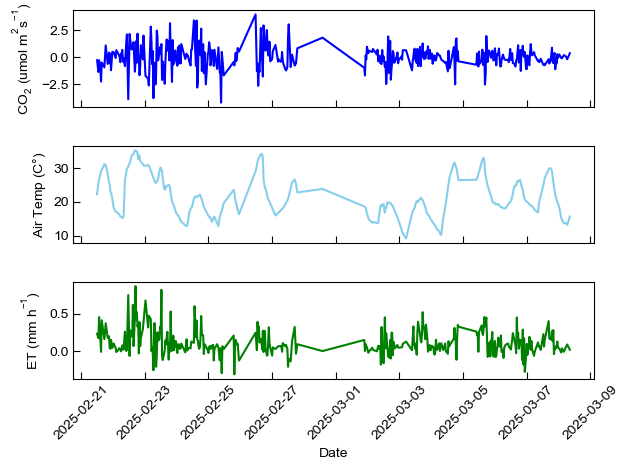

In [299]:
#Timeseries of CO2 flux, air temp, and ET
plt.subplot(311)
plt.plot(df.timestamp,df.co2_flux, color='b')
plt.ylabel(r"CO$_2$ (umol m$^2$s$^{-1}$)")
plt.tick_params(axis="x", direction="in", length=5, labelbottom=False)
plt.tick_params(axis="y", direction="in", length=5)


plt.subplot(312)
plt.plot(df.timestamp,df.air_temp_c, color='skyblue')
plt.ylabel("Air Temp (C$\\degree$)")
plt.tick_params(axis="x", direction="in", length=5, labelbottom=False)
plt.tick_params(axis="y", direction="in", length=5)


plt.subplot(313)
plt.plot(df.timestamp,df.ET, color='green')
plt.xlabel("Date")
plt.ylabel(r"ET (mm h$^{-1}$)")
plt.tick_params(axis="x", direction="in", length=5)
plt.tick_params(axis="y", direction="in", length=5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

plt.savefig('timeseries.pdf',dpi=300)
plt.savefig('timeseries.png',dpi=300)

plt.show()

### PCA

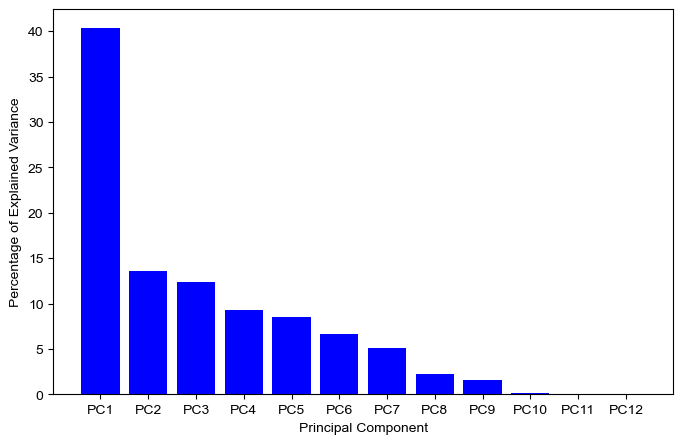

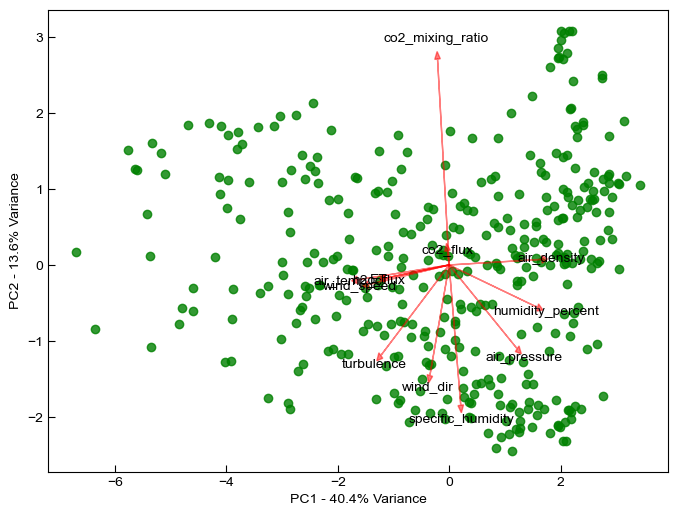

In [293]:
#Font size set above was too small for this plot
plt.rcParams['font.size'] = 10 

#Select relevant columns 
selected_data = [2,3,4,5,6,8,9,10,11,12,13,15]
df_selected = df[df.columns[selected_data]]

Labels = list(df.columns[selected_data]) 

#Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected)

#Perform PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

#Scree Plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(8,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels, color='blue')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()

#Convert PCA results to a DataFrame
pca_df = pd.DataFrame(pca_data, columns=labels)

#PCA scatter plot (PC1 vs PC2)
plt.figure(figsize=(8,6))
plt.scatter(pca_df.PC1, pca_df.PC2, color='green', alpha=0.8)
#plt.title('PCA of CO₂ Flux and Environmental Factors')
plt.xlabel(f'PC1 - {per_var[0]}% Variance')
plt.ylabel(f'PC2 - {per_var[1]}% Variance')
plt.tick_params(axis="x", direction="in", length=5)
plt.tick_params(axis="y", direction="in", length=5)

#Plot variable loadings
scale = 4
for i in range (pca.components_.T.shape[0]):
        plt.arrow(0, 0, pca.components_.T[i,0]*scale, pca.components_.T[i,1]*scale, 
                 color='red', alpha=0.5, head_width=0.1, head_length=0.1)
        plt.text(pca.components_.T[i,0]*scale*1.1, pca.components_.T[i,1]*scale*1.1,Labels[i], color = 'black', ha = 'center', va = 'center')

plt.savefig('PCA.pdf',dpi=300)
plt.savefig('PCA.png',dpi=300)
plt.show()

#pca.explained_variance_ratio_

### Correlation between Flux and Wind Direction

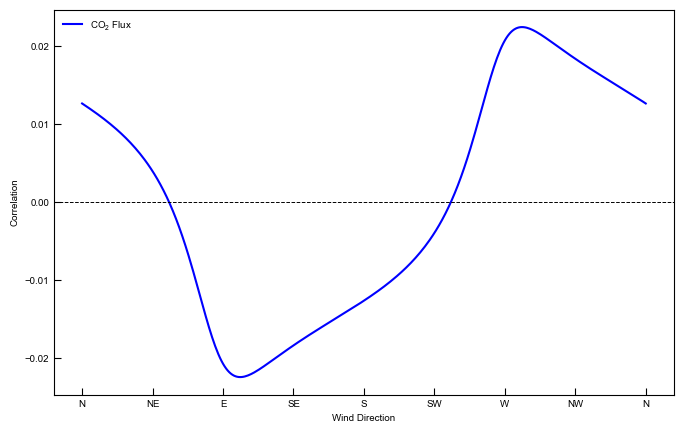

In [226]:
#Convert wind direction from degrees to radians
d = df.wind_dir * (np.pi / 180)
s = df.wind_speed
c = df.co2_flux

#Define angles in radians (0 to 2π)
a = np.linspace(0, 2 * np.pi, 361)  

#Compute correlation for each angle
correlations = []
for angle in a:
    x = s * (np.cos(d) * np.cos(angle) + np.sin(d) * np.sin(angle))  # Compute projected wind component
    
    #Ensure no NaN values before correlation calculation
    valid_mask = ~np.isnan(x) & ~np.isnan(c)
    x_valid = x[valid_mask]
    c_valid = c[valid_mask]
    
    #Compute correlation only if there are enough valid points
    if len(x_valid) > 1 and np.std(x_valid) > 0:  # Ensure variance > 0
        correlation = np.corrcoef(x_valid, c_valid)[0, 1]
    else:
        correlation = np.nan  # Assign NaN if correlation is not computable
    
    correlations.append(correlation)

#Define cardinal directions and their corresponding angles
cardinal_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']  # Repeat 'N' at 360°
cardinal_degrees = np.linspace(0, 360, 9)  # 0° to 360° in 8 steps

#Plot the correlation vs. wind direction angle
plt.figure(figsize=(8, 5))
plt.plot(a * (180 / np.pi), correlations, color='b', linewidth=1.5, label=r'CO$_2$ Flux')  # Convert a to degrees for plotting
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Reference line at y=0

#Set x-axis labels to cardinal directions
plt.xticks(cardinal_degrees, cardinal_labels)

plt.xlabel('Wind Direction')
plt.ylabel('Correlation')
plt.tick_params(axis="x", direction="in", length=5)
plt.tick_params(axis="y", direction="in", length=5)
plt.grid(False)
plt.legend(loc="upper left", frameon=False)


plt.savefig('directioncorr.pdf',dpi=300)
plt.savefig('directioncorr.png',dpi=300)

plt.show()

### Windrose and wind speed/CO2 correlation

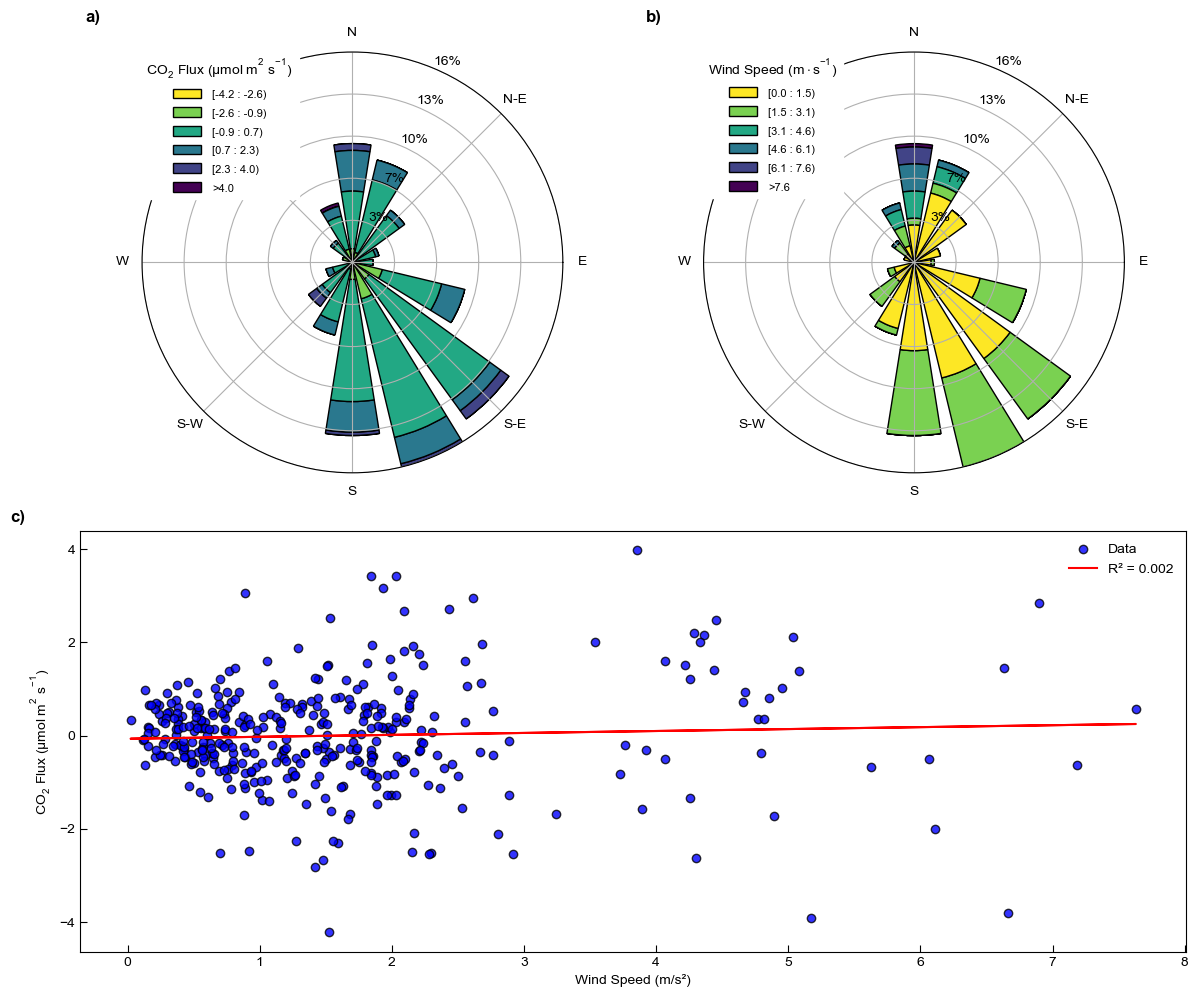

In [301]:
#Create figure 
fig = plt.figure(figsize=(12, 10))

#Windrose: CO2 Flux
ax1 = fig.add_subplot(2, 2, 1, projection="windrose")
ax1.bar(df.wind_dir, df.co2_flux, normed=True, opening=0.8, edgecolor="black", cmap=cm.viridis_r)
fmt = '%.0f%%' #
yticks = ticker.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)
ax1.set_legend(title=r"CO$_2$ Flux (µmol m$^2$ s$^{-1}$)", loc="upper left", frameon=True, facecolor='white', edgecolor='white', framealpha=1)
ax1.text(-0.1, 1.1, "a)", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")

#Windrose: Wind Speed
ax2 = fig.add_subplot(2, 2, 2, projection="windrose")
ax2.bar(df.wind_dir, df.wind_speed, normed=True, opening=0.8, edgecolor='black', cmap=cm.viridis_r)
fmt = '%.0f%%' #
yticks = ticker.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
ax2.set_legend(title=r"Wind Speed ($m\cdot s^{-1}$)", loc="upper left", frameon=True, facecolor='white', edgecolor='white', framealpha=1)
ax2.text(-0.1, 1.1, "b)", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")

#Correlation Scatter Plot spanning two columns
ax3 = fig.add_subplot(2, 1, 2)

#Compute correlation
correlation = df["wind_speed"].corr(df["co2_flux"])
r_squared = correlation**2  # Compute R²
ax3.scatter(df["wind_speed"], df["co2_flux"], alpha=0.8, color="blue", edgecolors="black", label="Data")

#Fit and plot a regression line
m, b = np.polyfit(df["wind_speed"], df["co2_flux"], 1)
ax3.plot(df["wind_speed"], m * df["wind_speed"] + b, color="red", linestyle="-", label=fr"R² = {r_squared:.3f}")

#Labels and Formatting
ax3.set_xlabel("Wind Speed (m/s²)")
ax3.set_ylabel(r"CO$_2$ Flux (µmol m$^2$ s$^{-1}$)")
ax3.legend(frameon=False)
ax3.tick_params(axis="x", direction="in", length=5)
ax3.tick_params(axis="y", direction="in", length=5)
ax3.grid(False)
ax3.text(-0.05, 1.05, "c)", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")

plt.tight_layout()

plt.savefig('3panel.pdf',dpi=300)
plt.savefig('3panel.png',dpi=300)

plt.show()